# Linear Elastic Transfer Function

This is a Jupyter IPython notebook -- see [here][1] for more information. This notebook documents calculation of a linear elastic transfer function for damped soil over damped rock.

[1]: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/

The first step is import the

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('talk')
sns.set_style('darkgrid')

## Site profile
Profile is defined by the thickness, velocity, and unit weight:

In [4]:
thickness = np.array([6, 25, 30, 30, np.inf])
velocity = np.array([220, 300, 460, 700, 760])
unit_wt = np.array([18, 18, 19, 22, 24])

## Calculation of average velocity
Compute the time averaged shear-wave velocity, but do not include the half-space layer that has infinite thickness.

In [5]:
total_thickness = thickness[:-1].sum()
avg_velocity = total_thickness / np.sum(thickness[:-1] / velocity[:-1])
avg_velocity

416.13203081292761

Compare this velocity with the profile:

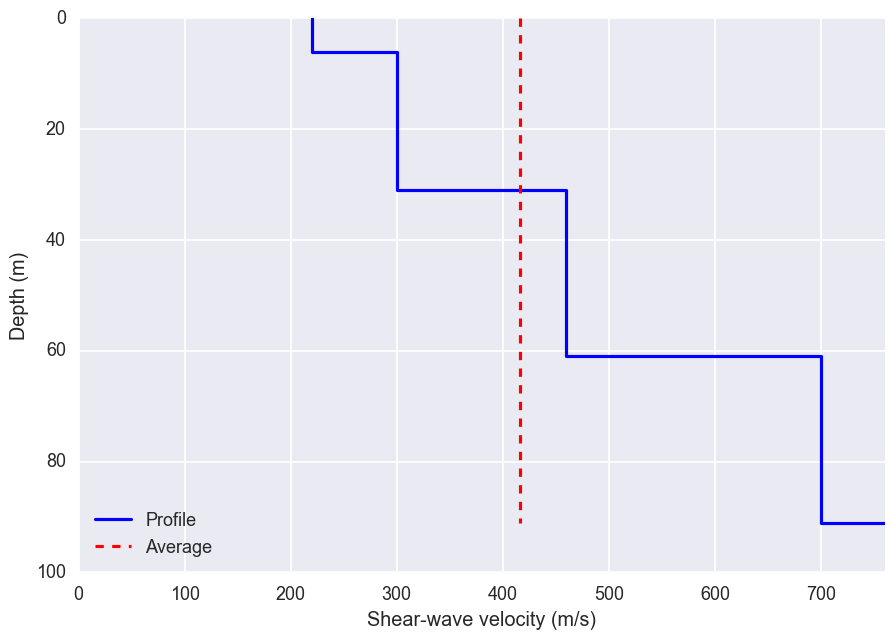

In [6]:
plt.plot(np.r_[velocity, velocity[-1]], np.r_[0, np.cumsum(thickness)],
         'b-', drawstyle='steps-pre', label='Profile')

plt.plot(2 * [avg_velocity], [0, total_thickness], 'r--', label='Average')

ax = plt.gca()
ax.set(
    xlabel='Shear-wave velocity (m/s)', xlim=(0, 760),
    ylabel='Depth (m)', ylim=(100, 0)
)
ax.legend(loc='lower left')

## Compute the characteristic site period

The site period is defined by:
    $$T_s = \frac{4 H}{\bar{v}_s}$$
where $H$ is the total height of the soil column, and $\bar{v}_s$ is the average velocity of the soil column.

In [7]:
site_period = (4 * total_thickness) / avg_velocity
site_period

0.87472237907020522

The frequency is the reciprocal of period, therefore the site frequency is the reciprocal of the site period:
$$f_s = \frac{1}{T_s}$$

In [8]:
site_freq = 1 / site_period
site_freq

1.1432198648706804

## Compute the transfer function

Compute the transfer function using Equation 7.26 from Kramer (1996). This requires calculation of the complex velocities defined in Equation 7.9. The complex velocity incorporate the damping of the material. This damping was assumed to be 3%, which was provided in the problem statement. Using the complex velocity and a representative unit weight, the impedance ratio is computed by Equation 7.23.

In [9]:
damping = 0.03
comp_vs_soil = avg_velocity * (1 + 1j * damping)
comp_vs_rock = velocity[-1] * (1 + 1j * damping)

imped = (np.average(unit_wt[:-1]) * comp_vs_soil) / (unit_wt[-1] * comp_vs_rock)

Transfer function may be computed at any frequency. To illustrate the transfer function, the frequency range is defined as 1024 points with log-spacing from 0.1 to 100 Hz. In application to a specific time series, the frequencies would correspond to the frequencies of the Fourier amplitude spectrum.

In [17]:
freq = np.logspace(-1, 2, num=1024)
ang_freq = 2 * np.pi * freq
wave_num = ang_freq / comp_vs_soil

trans_func = 1 / (np.cos(wave_num * total_thickness) +
                  1j * imped * np.sin(wave_num * total_thickness))

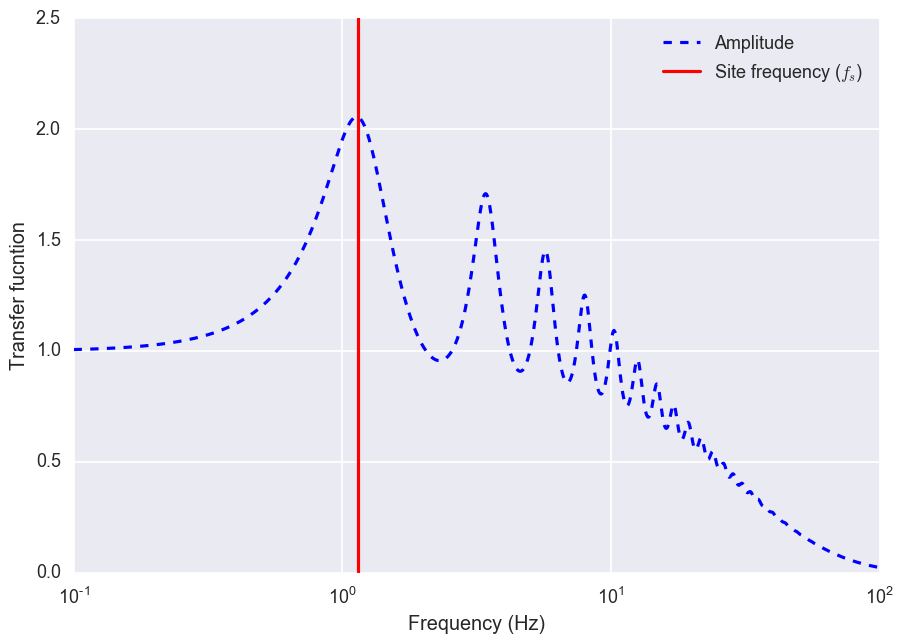

In [18]:
plt.plot(freq, np.abs(trans_func), 'b--', label='Amplitude')
plt.axvline(site_freq, color='r', label='Site frequency ($f_s$)')
ax = plt.gca()
ax.set(
    xlabel='Frequency (Hz)', xscale='log',
    ylabel='Transfer fucntion'
)
ax.legend(loc='upper right')

## Streamlining the calculation
Use Python classes and functions to clean up the calculation of the transfer function.

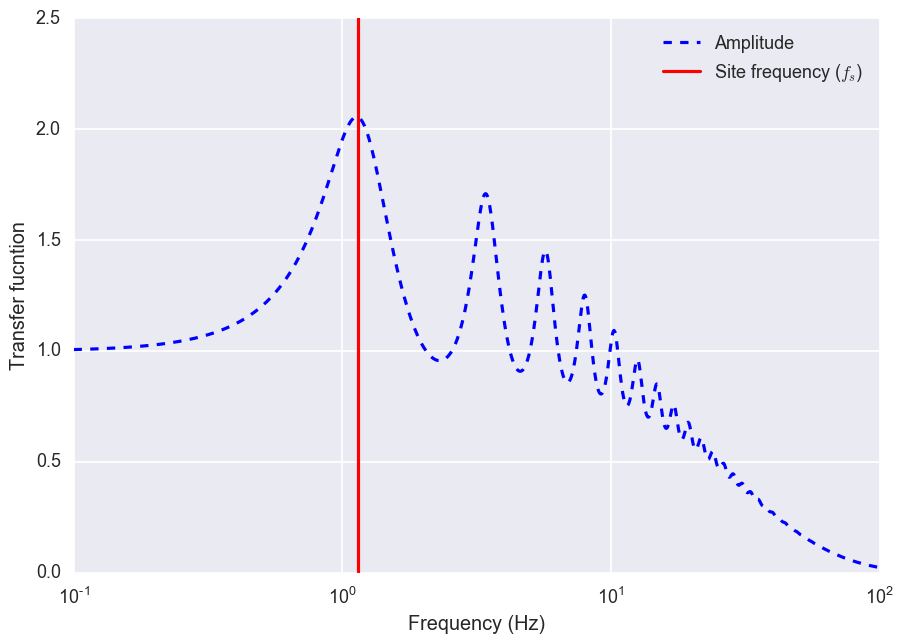

In [20]:
class Material:
    def __init__(self, velocity, unit_wt, damping, thickness=np.Inf):
        self._velocity = velocity
        self._unit_wt = unit_wt
        self._damping = damping
        self._thickness = thickness
    
    @property
    def thickness(self):
        return self._thickness
    
    @property
    def comp_vel(self):
        return self._velocity * (1 + 1j * self._damping)
    
    @property
    def imped(self):
        return self._unit_wt * self.comp_vel
    
    def wave_num(self, freq):
        return 2 * np.pi * freq / self.comp_vel
    
def calc_trans_func(freq, soil, rock):
    imped_ratio = soil.imped / rock.imped
    wave_num = soil.wave_num(freq)
    
    return 1 / (np.cos(wave_num * soil.thickness) +
                  1j * imped * np.sin(wave_num * soil.thickness))

soil = Material(avg_velocity, np.average(unit_wt[:-1]), 0.03, total_thickness)
rock = Material(velocity[-1], unit_wt[-1], 0.03)

freq = np.logspace(-1, 2, num=1024)
trans_func = calc_trans_func(freq, soil, rock)

plt.plot(freq, np.abs(trans_func), 'b--', label='Amplitude')
plt.axvline(site_freq, color='r', label='Site frequency ($f_s$)')
ax = plt.gca()
ax.set(
    xlabel='Frequency (Hz)', xscale='log',
    ylabel='Transfer fucntion'
)
ax.legend(loc='upper right')